# 1: Imports & first glance at the dataset

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import  StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from IPython.display import clear_output
import plotly.subplots as sp

In [2]:
data_jul14 = pd.read_csv("src/uber-raw-data-jul14.csv")
data_jul14

,Date/Time,Lat,Lon,Base
0,7/1/2014 0:03:00,40.7586,-73.9706,B02512
1,7/1/2014 0:05:00,40.7605,-73.9994,B02512
2,7/1/2014 0:06:00,40.7320,-73.9999,B02512
3,7/1/2014 0:09:00,40.7635,-73.9793,B02512
4,7/1/2014 0:20:00,40.7204,-74.0047,B02512
...,...,...,...,...
796116,7/31/2014 23:22:00,40.7285,-73.9846,B02764
796117,7/31/2014 23:23:00,40.7615,-73.9868,B02764
796118,7/31/2014 23:29:00,40.6770,-73.9515,B02764
796119,7/31/2014 23:30:00,40.7225,-74.0038,B02764


# 2: Data preprocessing

In [3]:
#Dropping unuseful Base column
df = data_jul14.drop("Base", axis=1)
df = df.sample(10000)

#Converting Date/Time into more useful formats
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M:%S')
#df['year'], df['month'] = df['Date'].dt.year, df['Date'].dt.month
#df['day'], df['day_of_week'] = df['Date'].dt.day, df['Date'].dt.dayofweek
df['day_of_week'], df['hour'] = df['Date/Time'].dt.dayofweek, df['Date/Time'].dt.hour

#Extracting DayOfWeek tags as strings
df['DayOfWeek'] = df['Date/Time'].dt.floor('H').dt.strftime('%A')

#Ordering values
df = df.sort_values(['day_of_week', 'hour'], ascending=True)


In [4]:
df.head()

,Date/Time,Lat,Lon,day_of_week,hour,DayOfWeek
619816,2014-07-07 00:34:00,40.7627,-73.9758,0,0,Monday
247194,2014-07-28 00:45:00,40.6465,-73.7899,0,0,Monday
127351,2014-07-14 00:27:00,40.7198,-73.9970,0,0,Monday
541776,2014-07-28 00:02:00,40.6466,-73.7773,0,0,Monday
665594,2014-07-14 00:03:00,40.7206,-73.9871,0,0,Monday


In [5]:
df_wday = df.drop(columns=['Date/Time', 'hour'])

In [6]:
df_hour = df.drop(columns=['Date/Time', 'day_of_week', 'DayOfWeek'])

# 3: Etude de clustering par dayofweek


In [7]:
wday_frame = df_wday['day_of_week'].unique()
wday_frames_list = []
for wday in wday_frame:
    wday_frames_list.append(df_wday[df_wday['day_of_week'] == wday])
print("Number of wdays: ", len(wday_frames_list))
print("Showing some examples:")
wday_frames_list[:1]

Number of wdays:  7
Showing some examples:


[            Lat      Lon  day_of_week DayOfWeek
 619816  40.7627 -73.9758            0    Monday
 247194  40.6465 -73.7899            0    Monday
 127351  40.7198 -73.9970            0    Monday
 541776  40.6466 -73.7773            0    Monday
 665594  40.7206 -73.9871            0    Monday
 ...         ...      ...          ...       ...
 135743  40.7420 -73.9831            0    Monday
 135774  40.7072 -74.0160            0    Monday
 468902  40.7035 -73.9907            0    Monday
 322598  40.7701 -73.8647            0    Monday
 135788  40.7707 -73.8655            0    Monday
 
 [1202 rows x 4 columns]]

## 3.1: Avec KMeans

In [8]:
best_k_list = []

for i in range (0, len(wday_frames_list)):
    wcss =  []
    sil = []
    k = []
    for j in range (2, 11):
        X = wday_frames_list[i][['Lat', 'Lon']]
        kmeans = KMeans(n_clusters= j)
        kmeans.fit(X)

        wcss.append(kmeans.inertia_)
        sil.append(silhouette_score(X, kmeans.predict(X)))
        k.append(j)

    df_k = pd.DataFrame({'k':k, 'WCSS':wcss, 'Silhouette Score':sil}).set_index('k')

    sc = StandardScaler()

    k_choice_scaled = sc.fit_transform(df_k)
    df_k['score'] = k_choice_scaled[:,1] - k_choice_scaled[:,0]

    best_k = df_k.index[df_k['score'].argmax()]
    best_k_list.append(best_k)

In [9]:
for i in range (0, len(wday_frames_list)):
    X = wday_frames_list[i][['Lat', 'Lon']]
    kmeans = KMeans(n_clusters = best_k_list[i])
    kmeans.fit(X)

    wday_frames_list[i]['Cluster_KMeans'] = kmeans.labels_
    wday_frames_list[i] = wday_frames_list[i].sort_values('Cluster_KMeans')
    clear_output(wait = True)

C:\Users\lucal\AppData\Local\Temp\ipykernel_41176\4088429237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wday_frames_list[i]['Cluster_KMeans'] = kmeans.labels_


In [10]:
wday_summary_list = []

for wday_frame in wday_frames_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the week day, and the % of the demand it represents:
    wday_demand = len(wday_frame)
    clusters_size = wday_frame.groupby(['day_of_week', 'Cluster_KMeans']).count()['Lat'].rename('count_km').reset_index(drop = False)
    clusters_size['km_%_of_wday_demand'] = (clusters_size['count_km'] / wday_demand * 100).astype(int)
    
    wday_summary = wday_frame.merge(clusters_size, on = ['day_of_week', 'Cluster_KMeans'])
    
    wday_summary['km_cluster / % of demand'] = 'cluster n° : ' + wday_summary['Cluster_KMeans'].astype(str) + ' / ' + wday_summary['km_%_of_wday_demand'].astype(str) + '%'
    
    wday_summary_list.append(wday_summary)

In [11]:
wday_summary_list[1]

,Lat,Lon,day_of_week,DayOfWeek,Cluster_KMeans,count_km,km_%_of_wday_demand,km_cluster / % of demand
0,40.7547,-73.9777,1,Tuesday,0,776,45,cluster n° : 0 / 45%
1,40.7469,-73.9839,1,Tuesday,0,776,45,cluster n° : 0 / 45%
2,40.7829,-74.0068,1,Tuesday,0,776,45,cluster n° : 0 / 45%
3,40.7633,-73.9704,1,Tuesday,0,776,45,cluster n° : 0 / 45%
4,40.7588,-73.9770,1,Tuesday,0,776,45,cluster n° : 0 / 45%
...,...,...,...,...,...,...,...,...
1707,40.8309,-73.9266,1,Tuesday,6,35,2,cluster n° : 6 / 2%
1708,40.8453,-73.9421,1,Tuesday,6,35,2,cluster n° : 6 / 2%
1709,40.8454,-73.9407,1,Tuesday,6,35,2,cluster n° : 6 / 2%
1710,40.8294,-73.9285,1,Tuesday,6,35,2,cluster n° : 6 / 2%


In [12]:
df_wday_res_conso = pd.DataFrame(columns=wday_summary_list[1].columns)
nb_days = len(wday_summary_list)
for day in range(nb_days):
    df_wday_res_conso = df_wday_res_conso.append(wday_summary_list[day])
    clear_output(wait = True)

C:\Users\lucal\AppData\Local\Temp\ipykernel_41176\3284841931.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wday_res_conso = df_wday_res_conso.append(wday_summary_list[day])


In [13]:
df_wday_res_conso[df_wday_res_conso['DayOfWeek'] == 'Saturday'].groupby('Cluster_KMeans').describe()

Lat                         Lon                       \
                count unique      top freq  count unique      top freq   
Cluster_KMeans                                                           
0               506.0  303.0  40.7405  6.0  506.0  284.0 -74.0063  5.0   
1                27.0   26.0  40.7739  2.0   27.0   27.0 -73.8592  1.0   
2                 3.0    3.0  40.2626  1.0    3.0    3.0 -74.0371  1.0   
3               103.0   93.0  40.6875  2.0  103.0   95.0 -73.9847  3.0   
4                18.0   18.0  40.8432  1.0   18.0   17.0 -73.8822  2.0   
5               313.0  224.0  40.7623  4.0  313.0  235.0 -73.9738  5.0   
6                 7.0    6.0  40.6879  2.0    7.0    7.0 -74.1820  1.0   
7                 1.0    1.0  40.8483  1.0    1.0    1.0 -73.1684  1.0   
8                29.0   22.0  40.6447  4.0   29.0   23.0 -73.7819  3.0   
9               140.0  119.0  40.7452  3.0  140.0  124.0 -73.9575  3.0   

               day_of_week         ... count_km      km_%_of_wday_demand  \
                     count unique  ...      top freq               count   
Cluster_KMeans                     ...                                     
0                      506      1  ...      506  506                 506   
1                       27      1  ...       27   27                  27   
2                        3      1  ...        3    3                   3   
3                      103      1  ...      103  103                 103   
4                       18      1  ...       18   18                  18   
5                      313      1  ...      313  313                 313   
6                        7      1  ...        7    7                   7   
7                        1      1  ...        1    1                   1   
8                       29      1  ...       29   29                  29   
9                      140      1  ...      140  140                 140   

                               km_cluster / % of demand         \
               unique top freq                    count unique   
Cluster_KMeans                                                   
0                   1  44  506                      506      1   
1                   1   2   27                       27      1   
2                   1   0    3                        3      1   
3                   1   8  103                      103      1   
4                   1   1   18                       18      1   
5                   1  27  313                      313      1   
6                   1   0    7                        7      1   
7                   1   0    1                        1      1   
8                   1   2   29                       29      1   
9                   1  12  140                      140      1   

                                           
                                 top freq  
Cluster_KMeans                             
0               cluster n° : 0 / 44%  506  
1                cluster n° : 1 / 2%   27  
2                cluster n° : 2 / 0%    3  
3                cluster n° : 3 / 8%  103  
4                cluster n° : 4 / 1%   18  
5               cluster n° : 5 / 27%  313  
6                cluster n° : 6 / 0%    7  
7                cluster n° : 7 / 0%    1  
8                cluster n° : 8 / 2%   29  
9               cluster n° : 9 / 12%  140  

[10 rows x 28 columns]

Since a slider wouldn't reset the cluster names used in the legend which would create a confusion between the clusters, we have to plot each frame frame seperatly

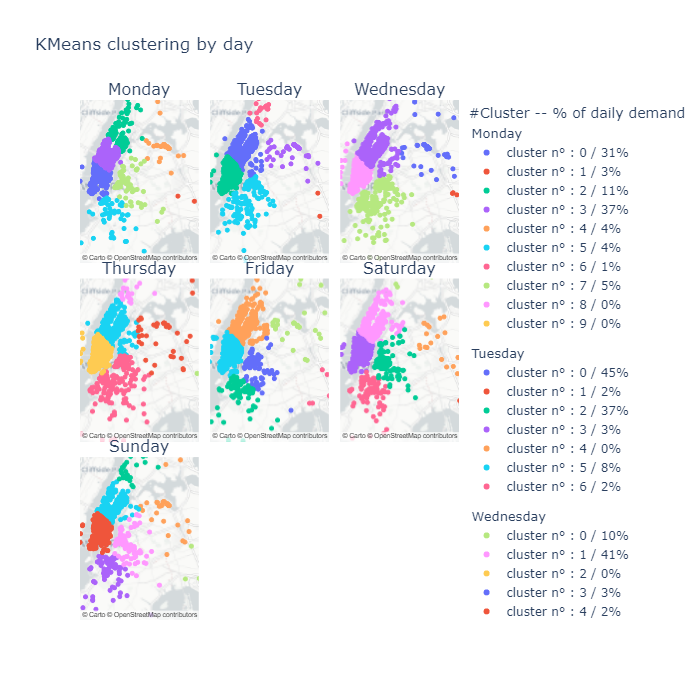

In [14]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figs = sp.make_subplots(rows = 3, cols = 3, subplot_titles = days_of_week, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {}, {}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 40.72, 'lon': -73.92},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each day mapbox
for day_index in range(len(days_of_week)):
    figs.update_layout({f'mapbox{day_index+1}' : default_mapbox_dict})


wday_index = 0

    # 1. Loop on subplots (days of week)

for day_index, day in enumerate(days_of_week):
    subplot_data = wday_summary_list[wday_index]
    row_number = day_index//3 + 1
    col_number = day_index%3 + 1
    print(day)
    print(row_number)
    print(col_number)

    # 2. Loop on traces (clusters)

    for cluster in subplot_data['Cluster_KMeans'].unique():
        cluster_data = subplot_data[subplot_data['Cluster_KMeans']==cluster]
        cluster_name = cluster_data['km_cluster / % of demand'].unique()[0]
        data_dict = {
            'type' : 'scattermapbox',
            'hoverinfo': 'all',
            'name': cluster_name,
            'subplot': f'mapbox{day_index+1}',
            'lat' : subplot_data['Lat'][subplot_data['Cluster_KMeans'] == cluster],
            'lon' : subplot_data['Lon'][subplot_data['Cluster_KMeans'] == cluster],
            'legendgrouptitle' : {'text' : day},
            'legendgroup' : day
        }
        figs.add_trace(data_dict)
        print(f"Trace created for Day : {day}, Cluster : {cluster}")
        clear_output(wait = True)
    wday_index += 1

# Plot and save figure
path = 'plots/KMeans_wday_clusters.html'
figs.write_html(path)

figs.update_layout(height = 700, title_text = "KMeans clustering by day", legend_title_text = "#Cluster -- % of daily demand")
figs.show('png')

# 3.2: Avec DBScan

In [15]:
eps = 0.005
metric = 'manhattan'
min_samples = 20
#for timeframe_wday in wday_frames_list:
#    min_samples = int(0.01 * np.mean(len(timeframe_wday)))

for i in range(len(wday_frames_list)):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
    dbscan.fit(wday_frames_list[i][['Lat', 'Lon']])
    wday_frames_list[i]['Cluster_DBscan'] = dbscan.labels_
    wday_frames_list[i] = wday_frames_list[i].sort_values('Cluster_DBscan')
print("Done !")

Done !


In [16]:
db_wday_summary_list = []

for wday_frame in wday_frames_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the wday, and the % of the wday demand it represents:
    wday_demand = len(wday_frame)
    wday_frame = wday_frame[wday_frame['Cluster_DBscan'] > -1] #remove -1 clusters, considered outliers
    clusters_size = wday_frame.groupby(['day_of_week', 'Cluster_DBscan']).count()['Lat'].rename('count_db').reset_index(drop = False)
    clusters_size['db_%_of_wday_demand'] = (clusters_size['count_db'] / wday_demand * 100).astype(int)
    
    wday_summary = wday_frame.merge(clusters_size, on = ['day_of_week', 'Cluster_DBscan'])
    
    wday_summary['db_cluster / % of demand'] = 'db_cluster n° : ' + wday_summary['Cluster_DBscan'].astype(str) + ' / ' + wday_summary['db_%_of_wday_demand'].astype(str) + '%'
    
    db_wday_summary_list.append(wday_summary)

In [17]:
db_wday_summary_list[0]

,Lat,Lon,day_of_week,DayOfWeek,Cluster_KMeans,Cluster_DBscan,count_db,db_%_of_wday_demand,db_cluster / % of demand
0,40.7425,-74.0014,0,Monday,0,0,73,6,db_cluster n° : 0 / 6%
1,40.7497,-74.0049,0,Monday,0,0,73,6,db_cluster n° : 0 / 6%
2,40.7421,-74.0042,0,Monday,0,0,73,6,db_cluster n° : 0 / 6%
3,40.7342,-74.0063,0,Monday,0,0,73,6,db_cluster n° : 0 / 6%
4,40.7514,-74.0051,0,Monday,3,0,73,6,db_cluster n° : 0 / 6%
...,...,...,...,...,...,...,...,...,...
642,40.6448,-73.7824,0,Monday,1,6,20,1,db_cluster n° : 6 / 1%
643,40.6449,-73.7822,0,Monday,1,6,20,1,db_cluster n° : 6 / 1%
644,40.6447,-73.7822,0,Monday,1,6,20,1,db_cluster n° : 6 / 1%
645,40.6448,-73.7823,0,Monday,1,6,20,1,db_cluster n° : 6 / 1%


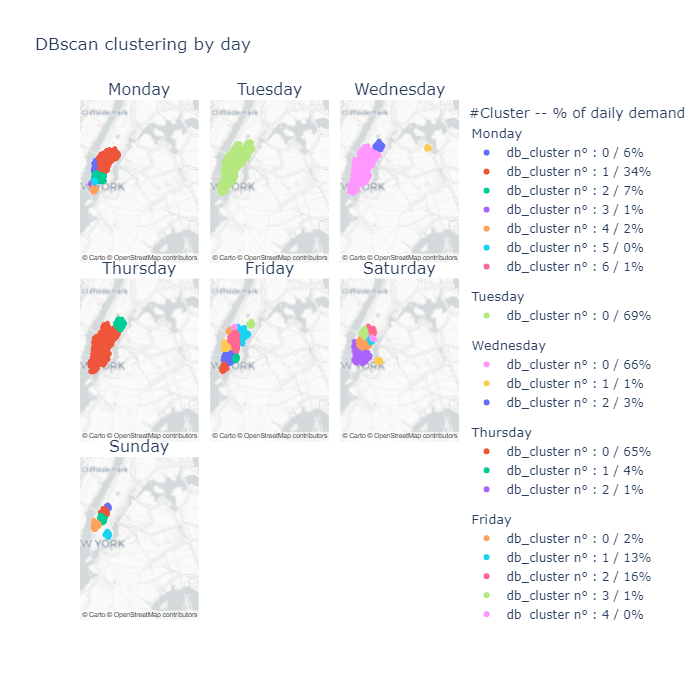

In [18]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figs = sp.make_subplots(rows = 3, cols = 3, subplot_titles = days_of_week, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {}, {}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 40.72, 'lon': -73.92},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each day mapbox
for day_index in range(len(days_of_week)):
    figs.update_layout({f'mapbox{day_index+1}' : default_mapbox_dict})


wday_index = 0

    # 1. Loop on subplots (days of week)

for day_index, day in enumerate(days_of_week):
    subplot_data = db_wday_summary_list[wday_index]
    row_number = day_index//3 + 1
    col_number = day_index%3 + 1
    print(day)
    print(row_number)
    print(col_number)

    # 2. Loop on traces (clusters)

    for cluster in subplot_data['Cluster_DBscan'].unique():
        cluster_data = subplot_data[subplot_data['Cluster_DBscan']==cluster]
        if len(cluster_data['db_cluster / % of demand'].unique()) != 0:
            cluster_name = cluster_data['db_cluster / % of demand'].unique()[0]
        else: 
            cluster_name = 'no cluster found'
        data_dict = {
            'type' : 'scattermapbox',
            'hoverinfo': 'all',
            'name': cluster_name,
            'subplot': f'mapbox{day_index+1}',
            'lat' : subplot_data['Lat'][subplot_data['Cluster_DBscan'] == cluster],
            'lon' : subplot_data['Lon'][subplot_data['Cluster_DBscan'] == cluster],
            'legendgrouptitle' : {'text' : day},
            'legendgroup' : day
        }
        figs.add_trace(data_dict)
        print(f"Trace created for Hour : Day : {day}, Cluster : {cluster}")
        clear_output(wait = True)
    wday_index += 1


# Plot and save figure
path = 'plots/DBscan_wday_clusters.html'
figs.write_html(path)

figs.update_layout(height = 700, title_text = "DBscan clustering by day", legend_title_text = "#Cluster -- % of daily demand")
figs.show('png')

# 4: Etude de clustering par heure

In [19]:
hour_frame = df_hour['hour'].unique()
hour_frames_list = []
for hour in hour_frame:
    hour_frames_list.append(df_hour[df_hour['hour'] == hour])
print("Number of hours: ", len(hour_frames_list))
print("Showing some examples:")
hour_frames_list[:1]

Number of hours:  24
Showing some examples:


[            Lat      Lon  hour
 619816  40.7627 -73.9758     0
 247194  40.6465 -73.7899     0
 127351  40.7198 -73.9970     0
 541776  40.6466 -73.7773     0
 665594  40.7206 -73.9871     0
 ...         ...      ...   ...
 312389  40.7235 -74.0016     0
 20435   40.7454 -73.8730     0
 709079  40.7395 -73.9873     0
 240436  40.7784 -73.9770     0
 709009  40.7510 -73.9462     0
 
 [216 rows x 3 columns]]

## 4.1: Avec KMeans 

In [20]:
best_k_list = []

for i in range (0, len(hour_frames_list)):
    wcss =  []
    sil = []
    k = []
    for j in range (2, 11):
        X = hour_frames_list[i][['Lat', 'Lon']]
        kmeans = KMeans(n_clusters= j)
        kmeans.fit(X)

        wcss.append(kmeans.inertia_)
        sil.append(silhouette_score(X, kmeans.predict(X)))
        k.append(j)

    df_k = pd.DataFrame({'k':k, 'WCSS':wcss, 'Silhouette Score':sil}).set_index('k')

    sc = StandardScaler()

    k_choice_scaled = sc.fit_transform(df_k)
    df_k['score'] = k_choice_scaled[:,1] - k_choice_scaled[:,0]

    best_k = df_k.index[df_k['score'].argmax()]
    best_k_list.append(best_k)

In [21]:
for i in range (0, len(hour_frames_list)):
    X = hour_frames_list[i][['Lat', 'Lon']]
    kmeans = KMeans(n_clusters = best_k_list[i])
    kmeans.fit(X)

    hour_frames_list[i]['Cluster_KMeans'] = kmeans.labels_
    hour_frames_list[i] = hour_frames_list[i].sort_values('Cluster_KMeans')
    clear_output(wait = True)

C:\Users\lucal\AppData\Local\Temp\ipykernel_41176\1221406741.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lucal\AppData\Local\Temp\ipykernel_41176\1221406741.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\lucal\AppData\Local\Temp\ipykernel_41176\1221406741.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [22]:
hour_summary_list = []

for hour_frame in hour_frames_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the week day, and the % of the demand it represents:
    hourly_demand = len(hour_frame)
    clusters_size = hour_frame.groupby(['hour', 'Cluster_KMeans']).count()['Lat'].rename('count_km').reset_index(drop = False)
    clusters_size['km_%_of_hour_demand'] = (clusters_size['count_km'] / hourly_demand * 100).astype(int)
    
    hour_summary = hour_frame.merge(clusters_size, on = ['hour', 'Cluster_KMeans'])
    
    hour_summary['km_cluster / % of demand'] = 'cluster n° : ' + hour_summary['Cluster_KMeans'].astype(str) + ' / ' + hour_summary['km_%_of_hour_demand'].astype(str) + '%'
    
    hour_summary_list.append(hour_summary)

Since a slider wouldn't reset the cluster names used in the legend which would create a confusion between the clusters, we have to plot each frame frame seperatly

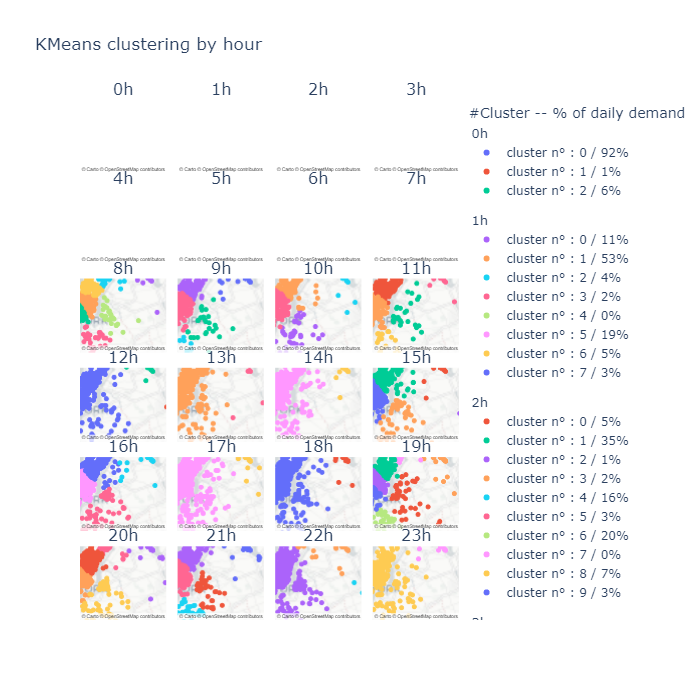

In [23]:
hours = []
for i in range(24):
    hour = f'{i}h'
    hours.append(hour)

figs = sp.make_subplots(rows = 6, cols = 4, subplot_titles = hours, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 40.72, 'lon': -73.92},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each hour mapbox
for hour_index in range(len(hours)):
    figs.update_layout({f'mapbox{hour_index+1}' : default_mapbox_dict})

hour_index = 0

    # 1. Loop on subplots (hours of week)

for hour_index, hour in enumerate(hours):
    subplot_data = hour_summary_list[hour_index]
    row_number = hour_index//3 + 1
    col_number = hour_index%3 + 1
    print(hour)
    print(row_number)
    print(col_number)

    # 2. Loop on traces (clusters)

    for cluster in subplot_data['Cluster_KMeans'].unique():
        cluster_data = subplot_data[subplot_data['Cluster_KMeans']==cluster]
        if len(cluster_data['km_cluster / % of demand'].unique()) != 0:
            cluster_name = cluster_data['km_cluster / % of demand'].unique()[0]
        else: 
            cluster_name = 'no cluster found'
        data_dict = {
            'type' : 'scattermapbox',
            'hoverinfo': 'all',
            'name': cluster_name,
            'subplot': f'mapbox{hour_index+1}',
            'lat' : subplot_data['Lat'][subplot_data['Cluster_KMeans'] == cluster],
            'lon' : subplot_data['Lon'][subplot_data['Cluster_KMeans'] == cluster],
            'legendgrouptitle' : {'text' : hour},
            'legendgroup' : hour
        }
        figs.add_trace(data_dict)
        print(f"Trace created for Hour : hour : {hour}, Cluster : {cluster}")
        clear_output(wait = True)
    hour_index += 1

# Plot and save figure
path = 'plots/KMeans_hour_clusters.html'
figs.write_html(path)

figs.update_layout(height = 700, title_text = "KMeans clustering by hour", legend_title_text = "#Cluster -- % of daily demand")
figs.show('png') 

## 4.2: Avec DBScan

In [24]:
eps = 0.005
metric = 'manhattan'
#min_samples = 5
for timeframe_hour in hour_frames_list:
    min_samples = int(0.01 * np.mean(len(timeframe_hour)))*2


for i in range(len(hour_frames_list)):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
    dbscan.fit(hour_frames_list[i][['Lat', 'Lon']])
    hour_frames_list[i]['Cluster_DBscan'] = dbscan.labels_
    hour_frames_list[i] = hour_frames_list[i].sort_values('Cluster_DBscan')
    #if i+1 in indexes_to_display_progress:  
    #    print(int(((i+1)/len(hour_frames_list)) * 100), "% complete", end = '\r')  # display progress percentage every 10%
print("Done !          ")

Done !          


In [25]:
hour_frames_list[0]['Cluster_DBscan'].value_counts()

-1    134
 2     26
 0     21
 1     11
 5     10
 3      7
 4      7
Name: Cluster_DBscan, dtype: int64

In [26]:
db_hour_summary_list = []

for hour_frame in hour_frames_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the hour, and the % of the hour demand it represents:
    hour_demand = len(hour_frame)
    hour_frame = hour_frame[hour_frame['Cluster_DBscan'] > -1] #remove -1 clusters, considered outliers
    clusters_size = hour_frame.groupby(['hour', 'Cluster_DBscan']).count()['Lat'].rename('count_db').reset_index(drop = False)
    clusters_size['db_%_of_hour_demand'] = (clusters_size['count_db'] / hour_demand * 100).astype(int)
    
    hour_summary = hour_frame.merge(clusters_size, on = ['hour', 'Cluster_DBscan'])
    
    hour_summary['db_cluster / % of demand'] = 'db_cluster n° : ' + hour_summary['Cluster_DBscan'].astype(str) + ' / ' + hour_summary['db_%_of_hour_demand'].astype(str) + '%'
    
    db_hour_summary_list.append(hour_summary)

In [27]:
db_hour_summary_list[1].head()

,Lat,Lon,hour,Cluster_KMeans,Cluster_DBscan,count_db,db_%_of_hour_demand,db_cluster / % of demand
0,40.7265,-73.9960,1,1,0,16,12,db_cluster n° : 0 / 12%
1,40.7206,-73.9908,1,1,0,16,12,db_cluster n° : 0 / 12%
2,40.7253,-73.9926,1,1,0,16,12,db_cluster n° : 0 / 12%
3,40.7253,-73.9928,1,1,0,16,12,db_cluster n° : 0 / 12%
4,40.7278,-73.9930,1,1,0,16,12,db_cluster n° : 0 / 12%


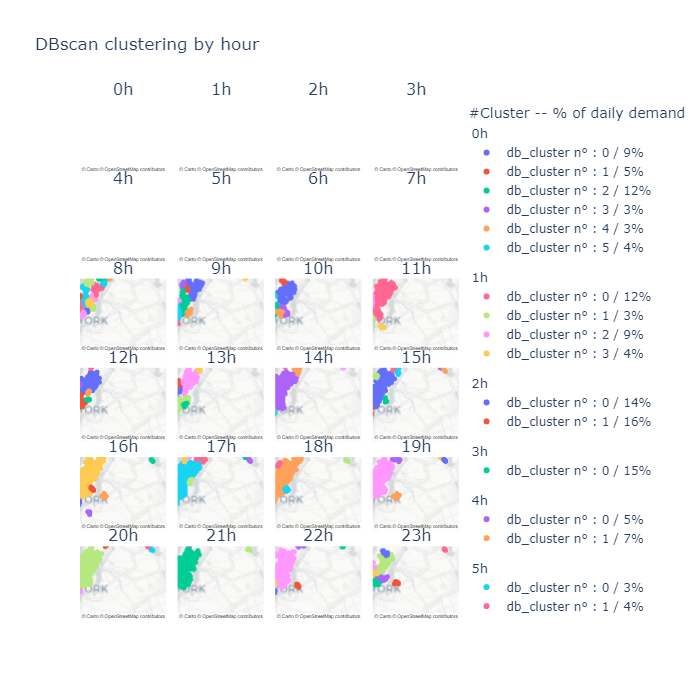

In [28]:
hours = []
for i in range(24):
    hour = f'{i}h'
    hours.append(hour)

figs = sp.make_subplots(rows = 6, cols = 4, subplot_titles = hours, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 40.72, 'lon': -73.92},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each hour mapbox
for hour_index in range(len(hours)):
    figs.update_layout({f'mapbox{hour_index+1}' : default_mapbox_dict})


hour_index = 0

    # 1. Loop on subplots (hours of week)

for hour_index, hour in enumerate(hours):
    subplot_data = db_hour_summary_list[hour_index]
    row_number = hour_index//3 + 1
    col_number = hour_index%3 + 1
    print(hour)
    print(row_number)
    print(col_number)

    # 2. Loop on traces (clusters)

    for cluster in subplot_data['Cluster_DBscan'].unique():
        cluster_data = subplot_data[subplot_data['Cluster_DBscan']==cluster]
        if len(cluster_data['db_cluster / % of demand'].unique()) != 0:
            cluster_name = cluster_data['db_cluster / % of demand'].unique()[0]
        else: 
            cluster_name = 'no cluster found'
        data_dict = {
            'type' : 'scattermapbox',
            'hoverinfo': 'all',
            'name': cluster_name,
            'subplot': f'mapbox{hour_index+1}',
            'lat' : subplot_data['Lat'][subplot_data['Cluster_DBscan'] == cluster],
            'lon' : subplot_data['Lon'][subplot_data['Cluster_DBscan'] == cluster],
            'legendgrouptitle' : {'text' : hour},
            'legendgroup' : hour
        }
        figs.add_trace(data_dict)
        print(f"Trace created for Hour : hour : {hour}, Cluster : {cluster}")
        clear_output(wait = True)
    hour_index += 1

# Plot and save figure
path = 'plots/DBscan_hour_clusters.html'
figs.write_html(path)

figs.update_layout(height = 700, title_text = "DBscan clustering by hour", legend_title_text = "#Cluster -- % of daily demand")
figs.show('png')

# Conclusion : 

The study that was realized here was made on a local machine with it's limited processing power. One could imagine that the clusters given by a study on the whole dataset would have been completely different. 

With more processing power, it could have been possible to realize the same study by creating individual frames by hour & day of the week or even an individual frame for each hour of each day of the week on every given month of the year, which would take into account specific intraday & weekly seasonality as well as yearly seasonality as one might assume that the demand doesn't follow the same pattern in summer and in winter by example.

Still, with the sample used for this study, we can see that the clusters concentrating the most demand are focused around the manhattan area, whatever the day of the week or the time of day.
Again, due to the small size of the sample we tend to get rather unprecise results, especially for more granular analysis like the hourly one (10 000 / 24 = an average of 417 rows per hour, uneavenly distributed with the smallest dataset at 3 am with 106 rows and the largest at 5pm with 755 rows)

In [29]:
10000/24

416.6666666666667

In [31]:
for i in range(24):
    rows = hour_frames_list[i].value_counts().sum()
    print(i, rows)

0 216
1 132
2 106
3 127
4 110
5 167
6 284
7 420
8 416
9 379
10 335
11 397
12 375
13 441
14 499
15 543
16 683
17 755
18 752
19 676
20 655
21 639
22 535
23 358


In [32]:
for i in range(7):
    rows = wday_frames_list[i].value_counts().sum()
    print(i, rows)

0 1202
1 1712
2 1883
3 1821
4 1285
5 1147
6 950
